In [955]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util
import statnlpbook.sequence as seq
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Sequence Labelling 

Many real-world applications can be cast as *sequence labelling* problems that involve assigning labels to each element in a sequence. For example, in *Part-Of-Speech tagging* each token in a sentence as assigned a part-of-speech such as verb or determiner that indicates the syntactic type of the token. In *Named Entity Tagging* we assign each token with the type of entity the token refers to, such as "Person" or "Organisation", or "None" if the token does not refer to an entity.  

## Sequence Labelling as Structured Prediction

The problem of sequence labelling is an obvious (and somewhat canonical) instance of structured prediction. Here the input space \\(\Xs\\) are sequences of words and the output space $\Ys$ are sequences of output labels. Our goal is again to define a model a model \\(s_{\params}(\x,\y)\\) that assigns high *scores* to the sequence of label \\(\y=y_1 \ldots y_n\\) that fits the input text \\(\x=x_1 \ldots x_n\\), and lower scores otherwise. The model will be parametrized by \\(\params\\), and these parameters we will learn from some training set \\(\train\\) of \\((\x,\y)\\) pairs. In contrast to the classification scenario the prediction problem $\argmax_\y s_{\params}(\x,\y)$ is now non-trivial in general, as we have to search through an exponentional number of label sequences. In practice this issue is overcome by making assumptions about the factorization structure of $s_{\params}(\x,\y)$ and/or search approximations that sacrifice the ability to find the true optimum of the search problem for more expressiveness. 

## Part-of-Speech Tagging as Sequence Labelling
Part-of-Speech (PoS) tagging is an important task within NLP. It is a standard pre-processing step in many tasks. For example, most dependency parsers assume as input PoS tagged sentences. Likewise, [Reverb](reverb), one of the most effective relation extraction methods, defines relations in terms of PoS sequences.

Traditionally, and based on the existence of corresponding annotated training sets, PoS tagging has been applied to quite restricted domains such newswire or biomedical texts. Recently there has been increasing interest in NLP in general, and PoS tagging in particular, for social media data. He we will focus on PoS tagging for tweets and use the [Tweebank dataset](http://www.cs.cmu.edu/~ark/TweetNLP/#pos) and the ["october 27" splits](https://github.com/brendano/ark-tweet-nlp/tree/master/data/twpos-data-v0.3/oct27.splits).

Let us load the data and look at an example tagged sentence.

In [956]:
train = seq.load_tweebank("../data/oct27.splits/oct27.train")
dev = seq.load_tweebank("../data/oct27.splits/oct27.dev")
test = seq.load_tweebank("../data/oct27.splits/oct27.test")
" ".join([w + "/" + t for w,t in zip(train[0][0],train[0][1])])

"I/O predict/V I/O won't/V win/V a/D single/A game/N I/O bet/V on/P ./, Got/V Cliff/^ Lee/^ today/N ,/, so/P if/P he/O loses/V its/L on/P me/O RT/~ @e_one/@ :/~ Texas/^ (/, cont/~ )/, http://tl.gd/6meogh/U"

We have printed the tokens of tweet paired with their PoS tag. The tags (such as "O", "V" and "^") are described in the [Tweebank annotation guideline](http://www.cs.cmu.edu/~ark/TweetNLP/annot_guidelines.pdf). For example, "O" denotes pronouns, "V" verbs and "^" proper nouns. 

In [957]:
# count tags here?

## Local Models / Classifiers
We will tackle sequence labelling as a (discriminative) structured prediction problem. This means we will build a model $p_\params(\y|\x)$ that computes the conditional probability of output label sequence $\y$ given input sequence $\x$. We will first consider the simplest type of model: a *fully factorised* or *local* model. In this model the probability of $\x$ and $\y$ is a product of *local* probabilities for the label $y_i$ of each token:

$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,i)
$$

In this model all labels are independent of each other. This assumption has a crucial benefit: inference (and hence training) in this model is trivial. To find the most likely assignment of labels under this model you can find the most likely tag for each token independently. Notice that each local term conditions on the complete input $\x$, not just on $x_i$. This is important, as the sentential context at position $i$ is often important to determine the tag at $i$.     

It is common to indicate this independence structure in a factor graph, a graphical representation of the model. In this representation each variable of the model (our per-token tag labels and the input sequence $\x$) is drawn using a circle, and *observed* variables are shaded. Each factor in the model (terms in the product) is drawn as a box that connects the variables that appear in the corresponding term. For example, the term $p_\params(y_3|\x,3)$ would connect the variables $y_3$ and $\x$. 

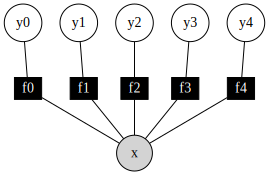

In [958]:
seq.draw_local_fg(5)

The independence assumptions of this model allow us to think of it not as a single sequence model, but a sequence of classification models. We have a classifier $p_\params(y|\x,i)$ that predicts the best class/tag for a token based on its sentence $\x$ and position $i$.

$$
  p_\params(y|\x,i) = \frac{1}{Z_\x} \exp \langle \repr(\x,i),\params_y \rangle
$$

Let us define a simple version of this model on the PoS tagging task defined above. Here we use a feature function (template) that has one active feature corresponding to the word $x_i$ observed at index $i$. 

In [1134]:
def feat_1(x,i):
    return {
        'word':x[i]
    }
local_1 = seq.LocalSequenceLabeler(feat_1, train)

/usr/local/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


Notice that in the above feature functions return a dictionary mapping a feature name (`word`) to a feature value (`x[i]`, the word at index `i`). This is not quite what we require `repr(\x,i)` to be, namely a function from $\x$ and $i$ to a real feature vector. However, internally this dictionary-based representation can be transformed into the desired form by defining a feature function template like so:

$$
f_{\text{word},w}(\x,i) = \indi\left[x_i = w\right]
$$

This means that we have one feature function $f_{\text{word},w}$ per word $w$. For example, the feature function $f_{\text{word},\text{"the"}}$ returns $1$ if $x_i = \text{"the"}$ and $0$ otherwise.  

We can assess the accuracy of this model on the development set.

In [1135]:
seq.accuracy(dev, local_1.predict(dev))

0.6680489321998756

This is a good start, but a macro-level evaluation score does not really show us where the approach fails and can be improved. One alternative view on the system is a confusion matrix that shows, for each pair of labels $l_1$ and $l_2$, how often $l_1$ was classified as $l_2$.    

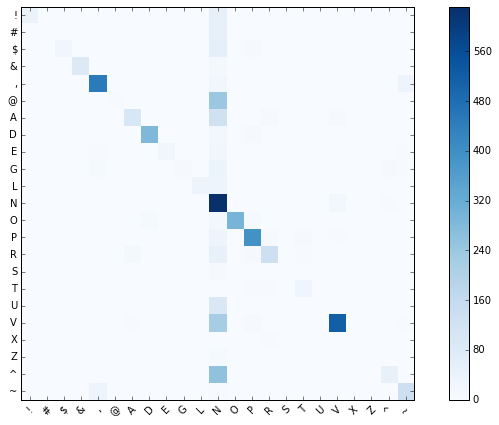

In [1136]:
seq.plot_confusion_matrix(dev, local_1.predict(dev))

This matrix shows a couple of interesting properties of our current model. First, we notice a relatively strong diagonal. This corresponds to correctly predicted labels and is a good sign. We also notice the 'N' (common nouns) column that receives a lot of counts. This means that many words that aren't common nouns are labelled as common nouns. This may not be surprising, as the large frequency of common nouns in the data (observe the very dark 'N'-'N' dot) could have 'N' the default class, chosen whenever there is too much uncertainty. 

The matrix enables us to spot systematic problems that, if fixed, may lead to substantial improvements. One problem is the fact that '@' (used for tokens that address twitter user ids) is never labelled correctly (its diagonal entry is missing). Why could this be? To investigate this further it is useful to look at the learned weight vector for this class.  

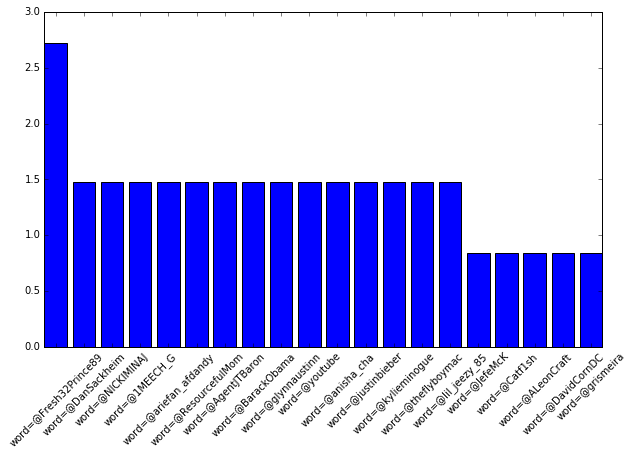

In [961]:
local_1.plot_lr_weights('@')

We see features for specific users such as "word=@justinbieber" corresponding to the feature function $f_{\text{word},\text{"@justinbieber"}}$. This is all the model can do right now: remembering words from the training set. This works for "@justinbieber", but for less popular twitter accounts that are unlikely to appear in the training set this means we cannot correctly classify them at test time. In other words, the model does not generalise well.  

In this particular case the problem can be easily solved. We notice that each of the "@" words starts (obviously) with a "@" symbol. If we turn this observation into a feature it should be simple to learn the class. We can do this by introducting a new feature `first_at` which returns `True` if $x_i \text{ starts with @}$ and `False` otherwise. Internally this is again transformed into a proper real-valued feature template.

In [1158]:
def feat_2(x,i):
    return {
        **feat_1(x,i),
        'first_at':x[i][0:1] == '@'
    }
local_2 = seq.LocalSequenceLabeler(feat_2, train)
seq.accuracy(dev, local_2.predict(dev))

/usr/local/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


0.7173958117354344

This looks much better. Of course this particular aspect of the problem is so deterministic that we could simply preprocess all words starting with @ and label them as '@' right away. But is important to know how easy such observations can be incorporated into the probabilistic model. 

To confirm that these results actually from improved '@' prediction, let us look at the confusion matrix again.

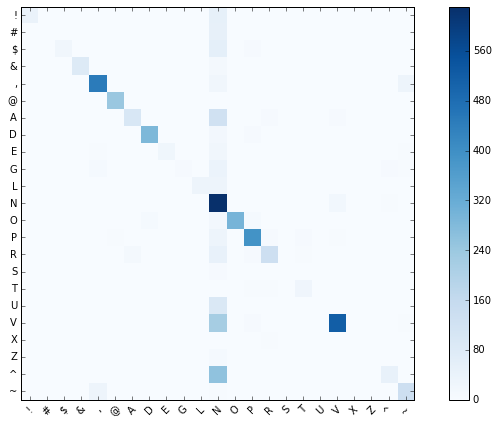

In [1137]:
seq.plot_confusion_matrix(dev, local_2.predict(dev))

Clearly, and unsurprisingly, we are now doing very well at predicting '@' labels. We can check that the model learned what we expected by also replotting its weight. (Exercise: figure out what happened to "Deja_fckn_Vu"). 

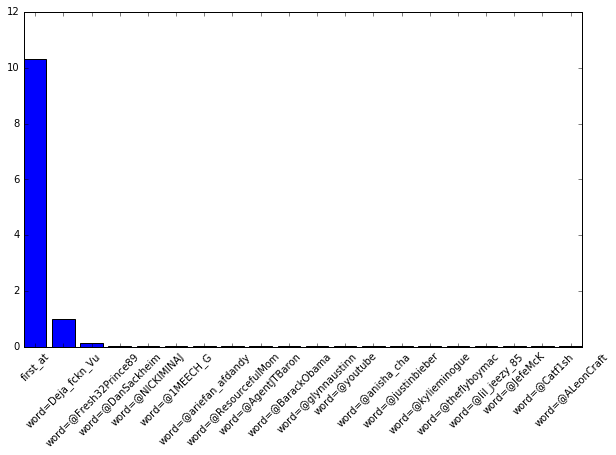

In [1140]:
local_2.plot_lr_weights('@')

There are other rows in the confusion matrix with empty diagonal entries, suggesting problems. But another approach to improving the system is to look for errors with high frequency. On such error corresponds to the problem of distinguishing proper nouns (label '^') such as "McDonals" or "smash burger" from common nouns (label 'N') such as "wife" or "rain". 

To better understand this problem it is useful to look at some actual predictions of the model where this error occurs. In particular, if we show for each error both the context of this error (say, the surrounding words) as well as the used feature representation, we can both spot potential bugs and get inspiration for additional features. In fact, **this type of debugging and sanity checking should be performed for any model you ever train**. Even if (or maybe: in particular when) your model is doing well it is worth to perform this type of micro analysis to spot potential bugs that lead to worse performance, or bugs that effectively mean you are cheating (e.g. because you are using gold data at test time).     

In [1180]:
util.Carousel(local_2.errors(dev[:10], filter_guess=lambda y: y=='N',filter_gold=lambda y: y=='^'))

In [967]:
def feat_3(x,i):
    return {
        **feat_2(x,i),
        'cap':x[i].islower()
    }
local_3 = seq.LocalSequenceLabeler(feat_3, train)
seq.accuracy(dev, local_3.predict(dev))

/usr/local/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


0.7389591540534937

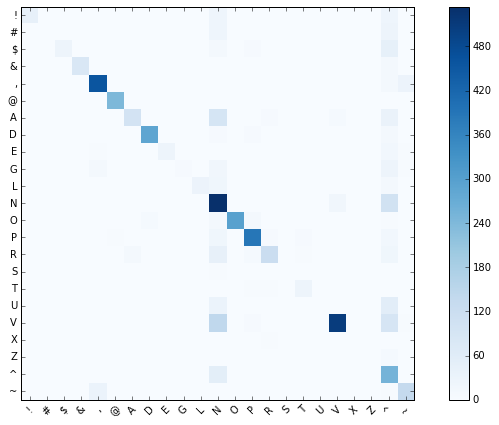

In [968]:
seq.plot_confusion_matrix(dev, local_3.predict(dev))

In [969]:
local_3.show_errors(dev[:10], filter_guess=lambda y: y=='N',filter_gold=lambda y: y=='V' )

---------
Gold:  V
Guess: N
the players and his wife [own] smash burger
{'first_at': False, 'word': 'own', 'cap': True}
---------
Gold:  V
Guess: N
RT @TheRealQuailman : Currently [laughing] at Laker haters .
{'first_at': False, 'word': 'laughing', 'cap': True}
---------
Gold:  V
Guess: N
@ShiversTheNinja [forgive] me for blowing up
{'first_at': False, 'word': 'forgive', 'cap': True}
---------
Gold:  V
Guess: N
@ShiversTheNinja forgive me for [blowing] up your youtube comment
{'first_at': False, 'word': 'blowing', 'cap': True}
---------
Gold:  V
Guess: N
Question : How CAN you [mend] a broken heart ?
{'first_at': False, 'word': 'mend', 'cap': True}
---------
Gold:  V
Guess: N
last night , but didn't [bother] calling Shawn because I'd
{'first_at': False, 'word': 'bother', 'cap': True}


In [1107]:
def feat_4(x,i):
    return {
        **feat_3(x,i),
        'prev': x[i-1] if i>0 else "PREV",
        'next': x[i+1] if i < len(x) - 1 else "NEXT",
        'last_3': " ".join(x[i][-3:]),
        'last_2': " ".join(x[i][-2:]),
        'lower': x[i].lower(),
    }
local_4 = seq.LocalSequenceLabeler(feat_4, train)
seq.accuracy(dev, local_4.predict(dev))

/usr/local/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


0.8243831640058055

In [971]:
local_4.show_errors(dev[:10], filter_guess=lambda y: y=='N',filter_gold=lambda y: y=='V' )

---------
Gold:  V
Guess: N
the players and his wife [own] smash burger
{'first_at': False, 'prev': 'wife', 'word': 'own', 'cap': True}
---------
Gold:  V
Guess: N
RT @TheRealQuailman : Currently [laughing] at Laker haters .
{'first_at': False, 'prev': 'Currently', 'word': 'laughing', 'cap': True}
---------
Gold:  V
Guess: N
@ShiversTheNinja [forgive] me for blowing up
{'first_at': False, 'prev': '@ShiversTheNinja', 'word': 'forgive', 'cap': True}
---------
Gold:  V
Guess: N
@ShiversTheNinja forgive me for [blowing] up your youtube comment
{'first_at': False, 'prev': 'for', 'word': 'blowing', 'cap': True}
---------
Gold:  V
Guess: N
night , but didn't bother [calling] Shawn because I'd just
{'first_at': False, 'prev': 'bother', 'word': 'calling', 'cap': True}


## Maximum Entropy Markov Models


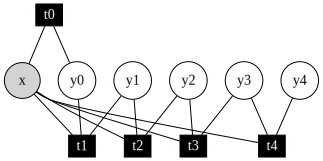

In [972]:
seq.draw_memm_fg(5)

In [1108]:
def memm_feat_1(x,i,hist):
    return {
        **feat_4(x,i),
         'prev_y': " ".join(hist),
    }

def memm_greedy_predict(memm: seq.MEMMSequenceLabeler, data, use_gold_history=False):
    result = []
    for x, y in data:
        y_guess = []
        for i in range(0, len(x)):
            prediction = memm.predict_next(x, i, y_guess if not use_gold_history else y)
            y_guess.append(prediction)
        result.append(y_guess)
    return result

memm_1 = seq.MEMMSequenceLabeler(memm_feat_1, train, order=1)
seq.accuracy(dev,memm_greedy_predict(memm_1, dev))

/usr/local/lib/python3.5/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


0.8293593199253576

In [1109]:
seq.accuracy(dev,memm_greedy_predict(memm_1, dev, use_gold_history=True))

0.8457391664938835

In [974]:
memm_1.input_repr(dev[1][0], 1, dev[1][1]),dev[1][1]
# memm_1.label_encoder.classes_

({'cap': False,
  'first_at': True,
  'prev': 'RT',
  'prev_y': '~',
  'word': '@TheRealQuailman'},
 ('~', '@', '~', 'R', 'V', 'P', '^', 'N', ','))

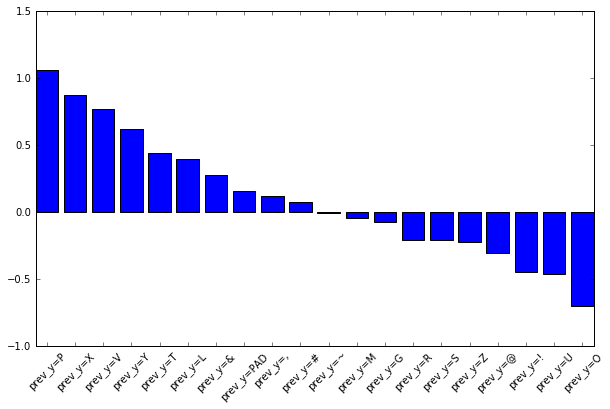

In [1069]:
memm_1.plot_lr_weights('D',feat_filter=lambda s: s.startswith("prev_"))

### Beam Search

In [1130]:
def memm_beam_search(memm, x, width=2):
    beam = [([],0.)]
    history = [beam]
    for i in range(0, len(x)):
        # use priority queue 
        candidates = []
        for (prev,score) in beam:
            scores = memm.predict_scores(x, i, prev)
            for label_index,label_score in enumerate(scores):
                candidates.append((prev + [memm.labels()[label_index]], score + label_score))
        beam = sorted(candidates, key=lambda x: -x[1])[:width]
        history.append([x[0:i+1]] + beam)
    return beam, history
            
def batch_predict(data, beam_predictor):
    return [beam_predictor(x)[0][0][0] for x,y in data]

seq.accuracy(dev, batch_predict(dev, lambda x: memm_beam_search(memm_1, x, 2)))

0.8322620775450964

In [1117]:
beam, history = memm_beam_search(memm_1, dev[5][0],5)
util.Carousel(history)

In [1095]:
dev[0][1]

('@',
 'O',
 'V',
 'P',
 'N',
 'N',
 ',',
 '$',
 'P',
 'D',
 'N',
 '&',
 'D',
 'N',
 'V',
 '^',
 '^')

In [ ]:
from collections import defaultdict
import math
def memm_viterbi_search(memm, x, width=2):
    beam = [([],0.)]
    history = [beam]
    for i in range(0, len(x)):
        # use priority queue 
        candidates = {}
        # assume that each prev sequence in the beam has a unique last element 
        candidates = defaultdict(lambda: ([], -math.inf))
        for (prev,score) in beam:
            scores = memm.predict_scores(x, i, prev)
            for label_index,label_score in enumerate(scores):
                new_score = score + label_score 
                _, old_score = candidates[label_index]
                if new_score > old_score:
                    candidates[label_index] = (prev + [memm.labels()[label_index]], new_score)
        # for each final label choose the highest scoring sequence          
        beam = sorted(candidates.values(), key=lambda x: -x[1])[:width]
        history.append([x[0:i+1]] + beam)
    return beam, history

beam, history = memm_viterbi_search(memm_1, dev[5][0],5)
util.Carousel(history)

In [1133]:
seq.accuracy(dev, batch_predict(dev, lambda x: memm_viterbi_search(memm_1, x, 5)))

0.8314327182251711

### Viterbi 


## CRF

In [ ]:
# Load CRF suite code


## Background Material
* [Tackling the Poor Assumptions of Naive Bayes Text Classifiers](https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf), Rennie et al, ICML 2003 
* [Simple Sentiment Classification](http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) ???